<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=250 ALIGN="right">
</figure>

# Stepwise Development of a Simple Analytic Element Model in Python
*Mark Bakker*

---

## AEM Model 1, a few wells

The head for a steady-state well at $(x,y)=(x_w,y_w)$ with discharge $Q$ in a confined aquifer with transmissivity $T$ may be written as:

$$h= \frac{Q}{2\pi T}\ln \left( r \right)$$

where $r = \sqrt{(x − x_w)^2 + (y − y_w)^2}$ is the radial distance from the well. Before writing the first Python function, tell Jupyter to place the `matplotlib` figures inside the notebook, and import `numpy` and `matplotlib`.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-talk')
#plt.rcParams['figure.figsize'] = 0.8 * np.array([6.4, 4.8])

A Python function to compute the head for a well is

In [2]:
def head(x, y, xw=0, yw=0, Q=100, T=100):
    r = np.sqrt((x - xw) ** 2 + (y - yw) ** 2)
    return Q / (2 * np.pi * T) * np.log(r)

A contour plot may be created by first creating an $x,y$ grid with the `np.meshgrid` function, then evaluating the head at each grid point (in one function call), and finally using a contouring routine to draw contours through the grid values.

<IPython.core.display.Javascript object>


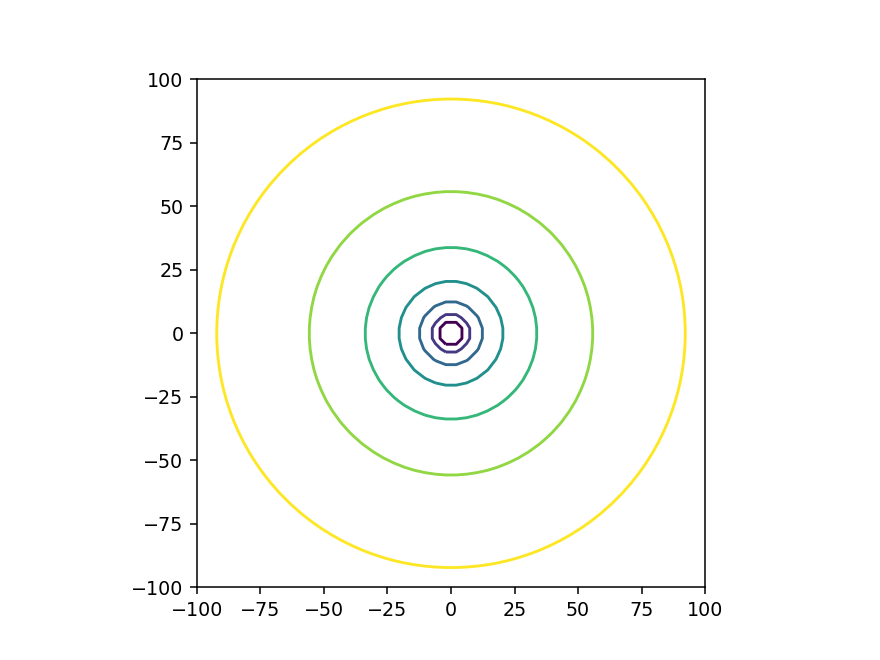

In [3]:
x, y = np.meshgrid(np.linspace(-100, 100, 50), np.linspace(-100, 100, 50))
h = head(x, y)
plt.figure()
plt.contour(x, y, h)
plt.axis('scaled');

Forty labeled contours may be created as follows

<IPython.core.display.Javascript object>


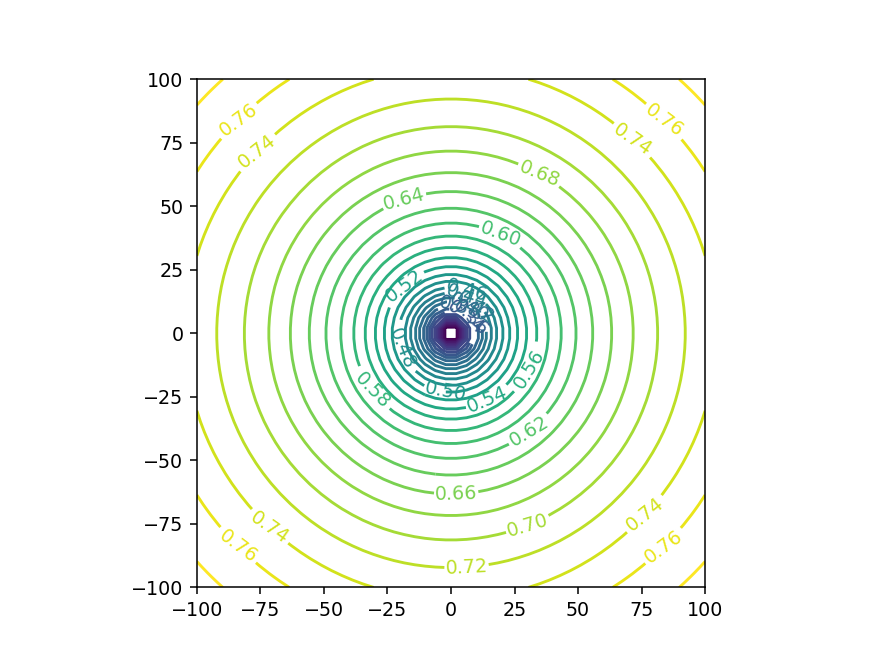

In [4]:
plt.figure()
cs = plt.contour(x, y, h, 40)
plt.clabel(cs, fmt='%1.2f')
plt.axis('scaled');

where `%1.2f` stands for a floating point number with two decimals.

The values of the contours may be specified (this is what you would commonly do). First determine the minimum and the maximum values of the head in the current window

In [5]:
print('min, max:', h.min(), h.max())

min, max: 0.168692060848 0.788094498918


Let's now draw contours from 0.2 up to 0.8 with steps of 0.05

<IPython.core.display.Javascript object>


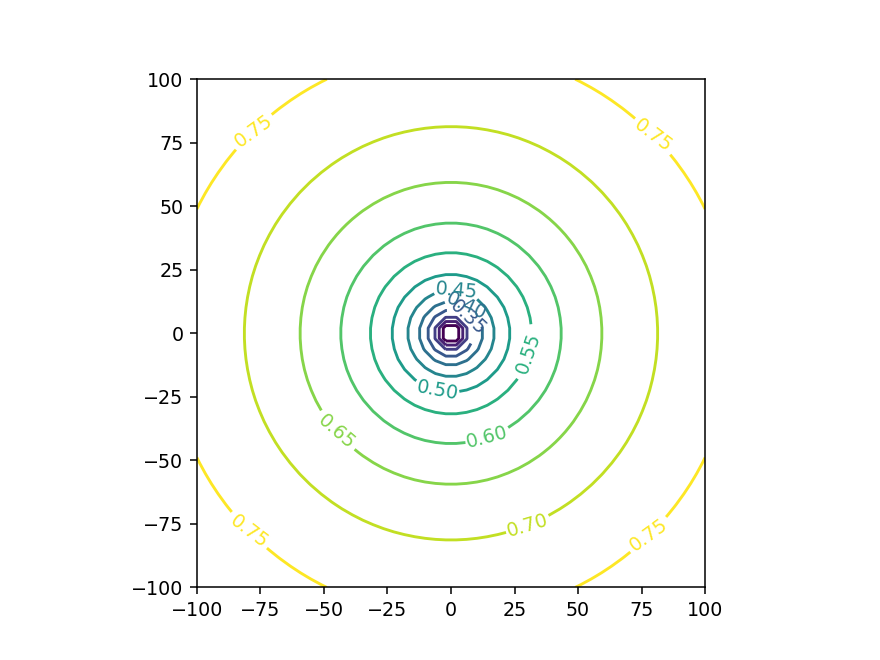

In [6]:
plt.figure()
cs = plt.contour(x, y, h, np.arange(0.2, 0.8, 0.05))
plt.clabel(cs, fmt='%1.2f')
plt.axis('scaled');

### Exercise 1

Create a contour plot for two wells. Well 1 is located at (−50, 0) and is an injection well with a
discharge Q = −100 m$^3$/d. Well 2 is located at (50, 0) and has a pumping rate Q = 100 m$^3$/d. The aquifer has a transmissivity $T=200$ m$^2$/d.

<IPython.core.display.Javascript object>


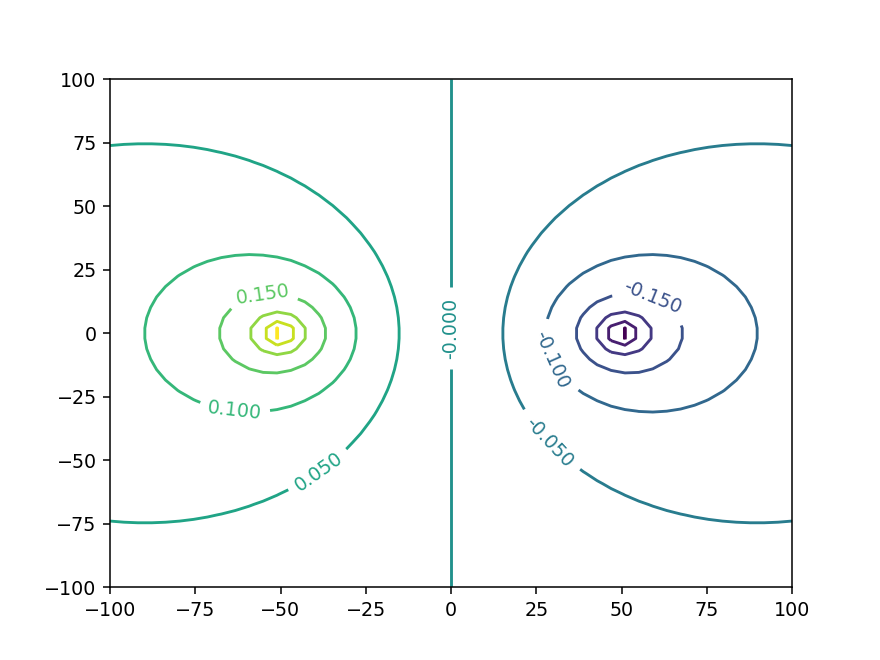

<a list of 7 text.Text objects>

In [7]:
h1 = head(x,y, xw=-50 , yw = 0, Q =-100, T = 200)
h2 = head(x,y, xw=50, yw=0, Q = 100, T = 200)
h = h1+h2
plt.figure()
cs = plt.contour(x,y,h,np.arange(-0.4,0.4,0.05))
plt.clabel(cs)

In [8]:
print(h.min(),h.max())

-0.301646754614 0.301646754614


## AEM Model 2, a Well class

A `Well` class is created so that every well is an instance of the `Well` class. The class consists of a constructor, which has the default (and somewhat cryptic) name `__init__`, and a function to compute the head. The location, discharge and tranmissivity are stored for every well as
attributes by the constructor.

In [35]:
class Well:
    def __init__(self, xw=0, yw=0, Q=100, T=100):
        self.xw, self.yw = xw, yw
        self.Q = Q
        self.T = T
    def head(self, x, y):
        r = np.sqrt((x - self.xw) ** 2 + (y - self.yw) ** 2)
        return self.Q / (2 * np.pi * self.T) * np.log(r)

The model with one well of Model 1 may now be recreated by using the following commands:

<IPython.core.display.Javascript object>


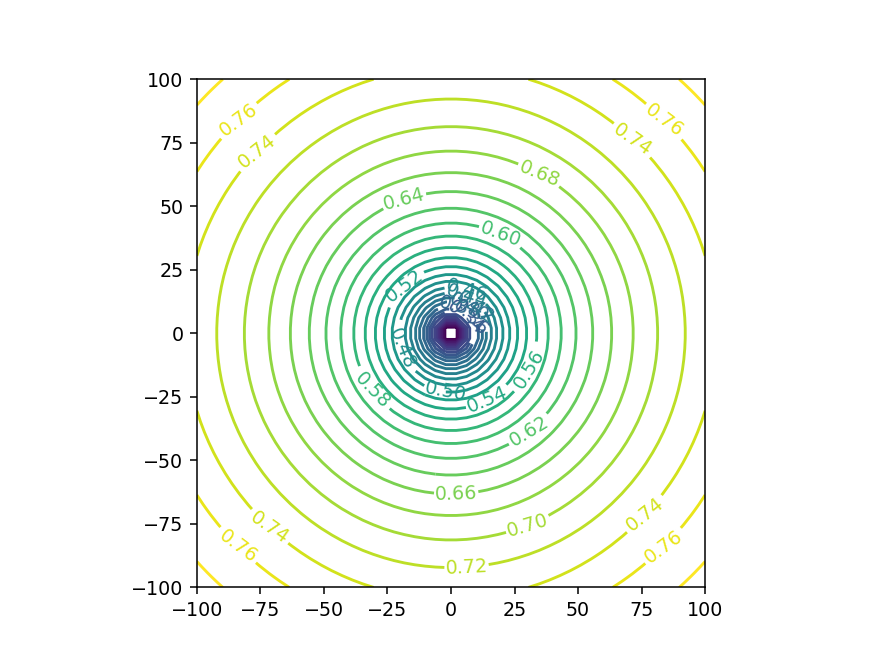

In [10]:
x, y = np.meshgrid(np.linspace(-100, 100, 50), np.linspace(-100, 100, 50))
w1 = Well(xw=0, yw=0, Q=100)
h = w1.head(x, y)
plt.figure()
cs = plt.contour(x, y, h, 40)
plt.clabel(cs, fmt='%1.2f')
plt.axis('scaled');

Note that 

`h = w1.head(x, y)` 

is shorthand for 

`h = Well.head(w1, x, y)`. 

### Exercise 2

Create a contour plot for two wells. Well 1 is located at (−50, 0) and is an injection well with a
discharge Q = −100 m$^3$/d. Well 2 is located at (50, 0) and has a pumping rate Q = 100 m$^3$/d. The aquifer has a transmissivity $T=200$ m$^2$/d.

<IPython.core.display.Javascript object>


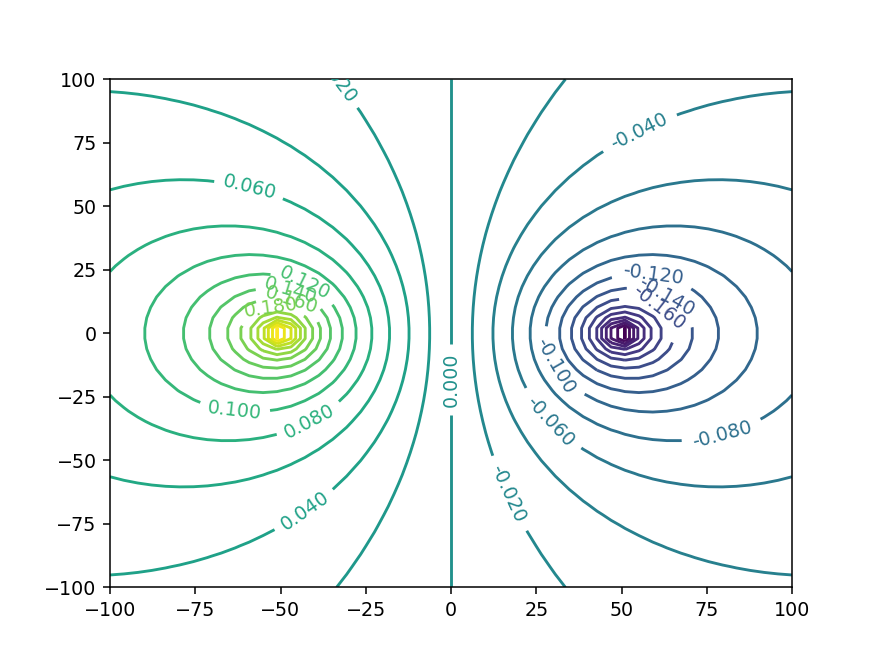

<a list of 18 text.Text objects>

In [36]:
xw1,yw1 = -50, 0
xw2, yw2 = 50,0
w1 = Well(xw= xw1,yw=yw1,Q = -100, T= 200)
w2 = Well(xw= xw2,yw=yw2,Q = 100, T= 200)
x, y = np.meshgrid(np.linspace(-100, 100, 50), np.linspace(-100, 100, 50))
plt.figure()
cs = plt.contour(x,y,w1.head(x,y)+w2.head(x,y), np.arange(-0.5,0.5,0.02))
plt.clabel(cs)


In [12]:
print(w1.head(x,y).min(),w2.head(x,y).max())

-0.413364991657 0.413364991657


## AEM Model 3, a Model class

Introduction of a `Well` class made computation of the head caused by multiple wells more convenient,
but we still have to keep track of all the wells in the model and we need to enter the (same) transmissivity for
every well separately. It makes more sense to gather all wells and define the transmissivity within one `Model` class, so that every model is an instance of the `Model` class. The `Model` class keeps track of a list with all the wells. 

Computations are formulated in terms of the discharge potential $ \Phi = Th$, so that a well
doesn’t need to know anything about the transmissivity of the aquifer. The potential for a well is:

$$ \Phi = \frac{Q}{2\pi}\ln \left( r \right)$$

The head is computed by the model by superimposing the potentials of all wells, and converting the final
potential back to a head as $h = \Phi / T$.

The `Well` class is modified so that it's first argument is the name of the model to which the well is added. Inside the constructor of the `Well` class, the element is added to the `elementlist` of the `Model`.

In [13]:
class Model:
    def __init__(self, T=100):
        self.T = T
        self.elementlist = []
    def head(self, x, y):
        rv = 0.0
        for e in self.elementlist:
            rv += e.potential(x, y)
        return rv / self.T

class Well:
    def __init__(self, ml, xw=0, yw=0, Q=100):
        self.xw, self.yw = xw, yw
        self.Q = Q
        ml.elementlist.append(self)
    def potential(self, x, y):
        r = np.sqrt((x - self.xw)**2 + (y - self.yw)**2)
        return self.Q / (2 * np.pi) * np.log(r)

The model with one well now becomes

<IPython.core.display.Javascript object>


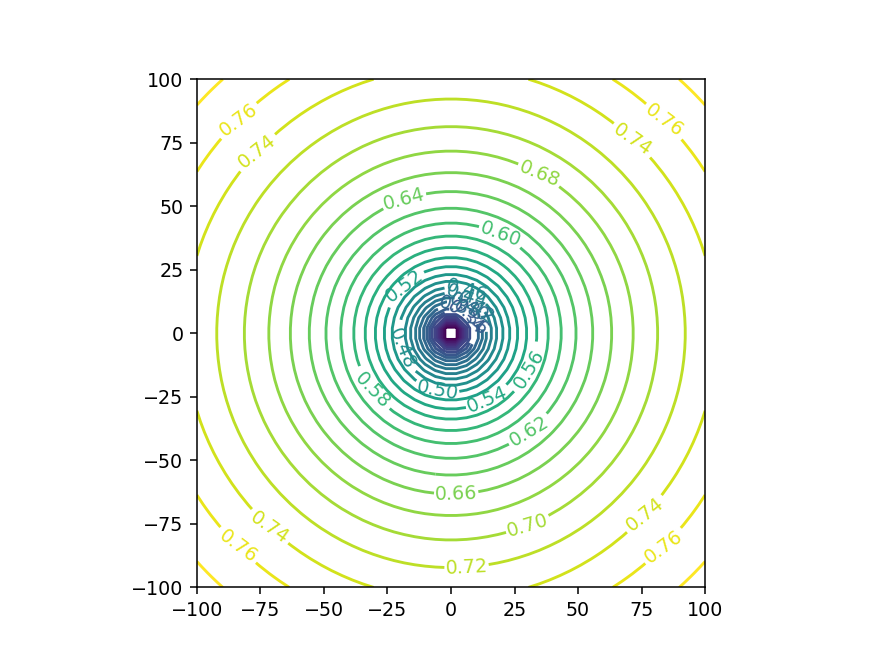

In [14]:
x, y = np.meshgrid(np.linspace(-100, 100, 50), np.linspace(-100, 100, 50))
ml = Model(T=100)
w1 = Well(ml, xw=0, yw=0, Q=100)
h = ml.head(x, y)
plt.figure()
cs = plt.contour(x, y, h, 40)
plt.clabel(cs, fmt='%1.2f')
plt.axis('scaled');

### Exercise 3

Create a contour plot with 10 wells randomly spaced between $(x, y) = (−100, −100)$ and $(x, y) =
(100, 100)$ with a random discharge between $Q=-100$ m$^3$/d and $Q=100$ m$^3$/d. The aquifer transmissivity is $T=100$ m$^2$/d. Use the `np.random.randint` function included in `numpy` to generate random numbers. Plot a red dot for each well.

<IPython.core.display.Javascript object>


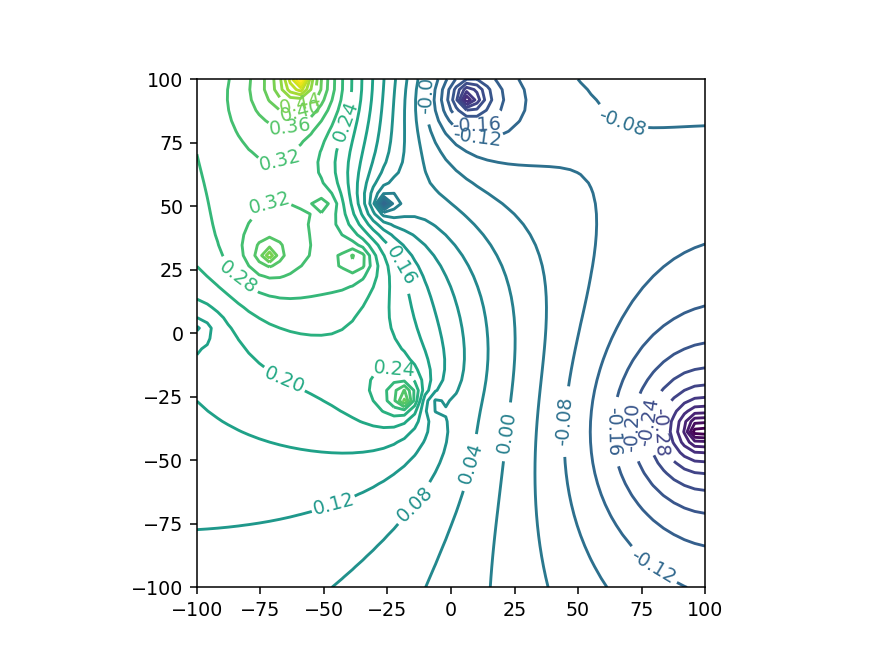

In [15]:
Xw = np.random.randint(-100,100,10)
Yw = np.random.randint(-100,100,10)
Q = np.random.randint(-100,100,10)
ml = Model(T=100)
for i in range(len(Xw)):
    W = Well(ml,Xw[i],Yw[i],Q[i])
x, y = np.meshgrid(np.linspace(-100, 100, 50), np.linspace(-100, 100, 50))
head = ml.head(x,y)
plt.figure()
cs = plt.contour(x, y, head, 40)
plt.clabel(cs, fmt='%1.2f')
plt.axis('scaled');

### Exercise 4

Add a uniform flow class that takes as input the uniform flow $Q_{x0}$ in the $x$-direction and the uniform flow $Q_{y0}$ in the $y$-direction. The potential for uniform flow is 

$$\Phi = -Q_{x0}x -Q_{y0}y$$

Make a contour plot for uniform flow in the North direction in an aquifer with $T=100$ m$^2$/d and a head drop of 2 m every 1000 m. Make sure that the head $h(x=0,y=0)=0$ and $h(x=0,y=1000)=-2$ m.

Next, add a well at the origin with a discharge $Q=200$ m$^3$/d and make a contour plot for a window $(-1000, -1000)$ to $(1000, 1000)$. 

In [16]:
class Model:
    def __init__(self,T=100):
        self.elementlist=[]
        self.T = T
    def head(self,x,y):
        phi = 0
        for e in self.elementlist:
            phi += e.potential(x,y)
        return phi/self.T
    
    
class Well:
    def __init__(self,model,xw,yw, Q, Qx, Qy):
        self.xw = xw
        self.yw = yw
        self.Q = Q
        self.Qx = Qx
        self.Qy = Qy
        self.model = model
        self.model.elementlist.append(self)
    def potential(self,x,y):
        r = np.sqrt((x-self.xw)**2+(y-self.yw)**2)
        potential = -self.Qx*x-self.Qy*y + self.Q/2/np.pi*np.log(r)
        return potential

** Uniform flow**

<IPython.core.display.Javascript object>


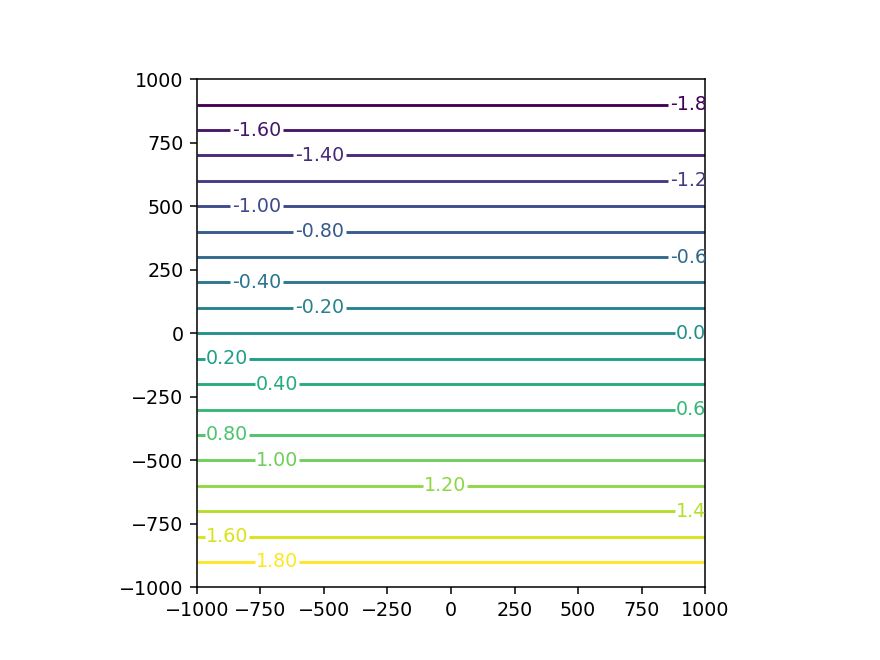

In [17]:
ml = Model(T=100)
x,y = np.meshgrid(np.linspace(-1000,1000,1000),np.linspace(-1000,1000,1000))
w1 = Well(ml,xw=0,yw=0,Q=0, Qx=0 , Qy=0.2 )
plt.figure()
cs = plt.contour(x, y, ml.head(x,y), 20)
plt.clabel(cs, fmt='%1.2f')
plt.axis('scaled');


In [18]:
ml.head(0,1000)

-2.0

** Uniform Flow superimpose pumping well**

<IPython.core.display.Javascript object>


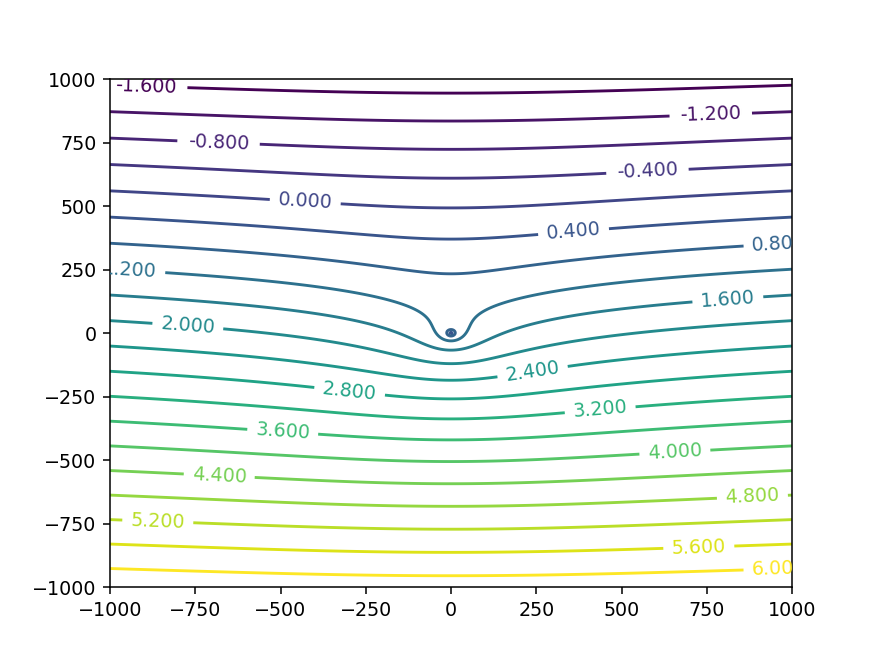

<a list of 20 text.Text objects>

In [19]:
w2 = Well(ml,xw=0,yw=0, Q=200, Qx = 0, Qy = 0.2)
plt.figure()
cs = plt.contour(x,y,ml.head(x,y),20)
plt.clabel(cs)

## AEM Model 4, Head specified wells

The next step is to add wells where we specify the head at the well instead of the discharge, and
compute what discharge is needed to achieve that head. The discharges of all head-specified wells need to be
solved simultaneously, as pumping at one well effects the head at another well and vice versa. Consider, for
example, two wells with desired heads $h_1$ and $h_2$ but unknown discharges $Q_1$ and $Q_2$; the radii of the two
wells are $R_1$ and $R_2$, respectively. The potential in the aquifer may be computed as

$$ \Phi (x,y) = Th(x,y) = \frac{Q_1}{2\pi}\ln\left( \sqrt{(x-x_1)^2+(y-y_1)^2}\right) + \frac{Q_2}{2\pi}\ln\left( \sqrt{(x-x_2)^2+(y-y_2)^2}\right) $$

The unknown discharges are computed from a system of two linear equations which are obtained by requiring
that the heads are $h_1$ and $h_2$ at wells 1 and 2, respectively (and thus the potentials need to be $ \Phi_1 = Th_1$
and $\Phi_2 = Th_2$). The head is computed at the radius of each well:

$$ \frac{Q_1}{2\pi} \ln ( R_1 ) + \frac{Q_2}{2\pi}\ln\sqrt{(x_1-x_2)+(y_1-y_2)} = \Phi_1$$

$$ \frac{Q_1}{2\pi} \ln \sqrt{(x_2-x_1)+(y_2-y_1)} + \frac{Q_2}{2\pi} \ln (R_2) = \Phi_2$$

This system of equations may be written in matrix form as

$$ \begin{pmatrix}
\frac{1}{2\pi}\ln(R_1) & \frac{1}{2\pi} \ln \sqrt{(x_1-x_2)+(y_1-y_2)} \\
\frac{1}{2\pi} \ln \sqrt{(x_2-x_1)+(y_2-y_1)} & \frac{1}{2\pi}\ln(R_2)
\end{pmatrix}
\begin{pmatrix}
Q_1 \\
Q_2
\end{pmatrix}
=
\begin{pmatrix}
\Phi_1  \\
\Phi_2
\end{pmatrix} $$

For an aquifer with $N$ head-specified wells, a system of $N$ linear equations in $N$ unknown discharges needs
to be solved.

The analytic element program is modified to incorporate head-specified wells and to compute a solution. The `Model` class is modified first. The `Model` class receives a `solve` method that loops through all elements in the `elementlist`. When an element has a unknown discharge, it calls the `equation` method of the element. The `equation` method needs to return one equation and a right-hand-side for that equation. The `solve` method stores all the equations in a matrix (one row at a time) and all the right-hand-sides in one array. Once the matrix and right-hand-side are filled, the system of equations is solved and the computed discharges are stored as the discharges of all the elements.

In [20]:
class Model:
    def __init__(self, T=100):
        self.T = T
        self.elementlist = []
    def head(self, x, y):
        # short version of summation
        return sum([e.potential(x, y) for e in self.elementlist]) / self.T
    def solve(self):
        self.Nunknowns = sum([e.Nunknowns for e in self.elementlist])
        matrix = np.zeros((self.Nunknowns, self.Nunknowns))
        rhs = np.zeros(self.Nunknowns)
        irow = 0
        for e in self.elementlist:
            if e.Nunknowns > 0:
                row, p = e.equation()
                matrix[irow] = row
                rhs[irow] = p
                irow += 1
        Qsol = np.linalg.solve(matrix, rhs)
        irow = 0
        for e in self.elementlist:
            if e.Nunknowns > 0:
                e.Q = Qsol[irow]
                irow = irow + 1

The `Well` class is modified such that it has a potential influence function called `potinf`, which returns the potential for a unit discharge. The potential function then reduces to the
`potinf` function multiplied with the discharge of the well. The `Well` class also sets its numbers of unknowns to zero (the discharge is specified) and stores the model to which it is added. 

In [21]:
class Well:
    def __init__(self, ml, xw=0, yw=0, Q=100):
        self.xw, self.yw = xw, yw
        self.Q = Q
        self.model = ml
        self.Nunknowns = 0
        self.model.elementlist.append(self)
    def potinf(self, x, y):
        r = np.sqrt((x - self.xw) ** 2 + (y - self.yw) ** 2)
        return 1.0 / (2 * np.pi) * np.log(r)
    def potential(self, x, y):
        return self.Q * self.potinf(x, y)

The new `HeadWell` class inherits all attributes and functions from the `Well` class. Three new attributes are added: the `xc` and `yc` locations where the head is specified (equal to $x_w+r_w$ and $y_w$, respectiely), and the potential at the well (the specified head multiplied with the transmissivity of the model). The number of unknowns is set to 1. A new `equation` method is defined. The `equation` method loops through all the elements of the model and builds one equation (one row) of the system of equations. The right-hand-side of the equation is initially the specified potential at the well. If an element has an unknown, it evaluates that element's `potinf` function at the well (point `xc`,`yc`) and stores that as the next value in the row of the matrix. If an element does not have an unknown, it evalutates that elements's `potential` function and subtracts it from the right-hand-side. Once it has looped through all elements, it returns the equation and right-hand-side.

In [22]:
class HeadWell(Well):
    def __init__(self, ml, xw=0, yw=0, h=1, rw=0.3):
        Well.__init__(self, ml, xw, yw, 0.0)
        self.xc = self.xw + rw
        self.yc = self.yw
        self.pot = h * self.model.T
        self.Nunknowns = 1
    def equation(self):
        row = np.zeros(self.model.Nunknowns)
        rhs = self.pot
        print(row)
        icol = 0
        for e in self.model.elementlist:
            if e.Nunknowns > 0:
                row[icol] = e.potinf(self.xc, self.yc)
                icol += 1
            else:
                rhs += -e.potential(self.xc, self.yc)
        return row, rhs

### Exercise 5

Consider an aquifer with a transmissivity $T=100$ m$^2$/d. The aquifer includes one well with a
specified discharge and two wells with a specified head (Table 1). Build a
model for the wells, solve the model, and make a contour plot. Verify that the head at the two head-specified
wells is indeed equal to the specified heads at the radius of the well $(x_w+r_w,y_w)$. What are the computed discharges of the two head-specified
wells?

#### Table 1: Data for head-specified wells example
| Well | $Q$ or $h$     | $x_w$ | $y_w$ | $r_w$ |
|------|---------------:|------:|------:|------:|
|  0   | $Q=100$        | 0     | -50   | 0.2   |
|  1   | $h=2$          | 50    |  50   | 0.2   |
|  2   | $h=2$          |-50    |  50   | 0.2   |

[ 0.  0.]
[ 0.  0.]


<IPython.core.display.Javascript object>


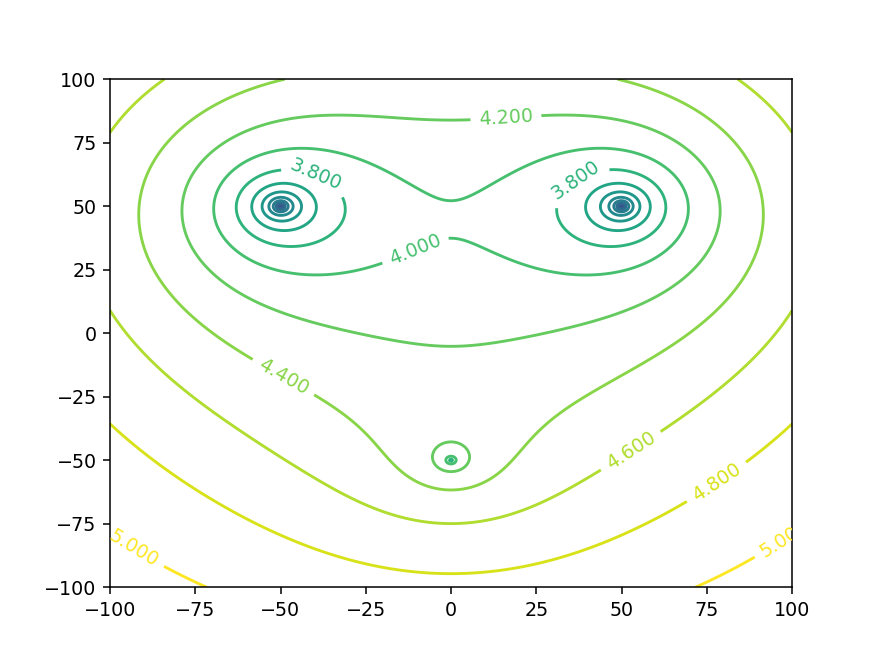

<a list of 9 text.Text objects>

In [23]:
ml = Model(T = 100)
w1 = Well(ml, xw=0, yw= -50 ,Q = 100)
w2 = HeadWell(ml,xw = 50, yw= 50,h=2,rw = 0.2)
w3 = HeadWell(ml,xw = -50, yw= 50,h=2,rw = 0.2)
ml.solve()
x,y = np.meshgrid(np.linspace(-100,100,1000),np.linspace(-100,100,1000))
plt.figure()
cs = plt.contour(x,y,ml.head(x,y),20)
plt.clabel(cs)

In [24]:
print('The discharge at well 1 is %.2f m^3/d'%(ml.elementlist[1].Q))
print('The discharge at well 2 is %.2f m^3/d'%(ml.elementlist[2].Q))

The discharge at well 1 is 262.12 m^3/d
The discharge at well 2 is 261.93 m^3/d


## AEM Model 5, Line-sinks

The last step is to add line-sinks with a known discharge and line-sinks with a specified head. The `Model` class and `Well` class are unchanged.

The complex potential for a line-sink is given by

$$\Omega = \Phi + i\Psi = \frac{Q}{2\pi(z_2-z_1)}\left[ (z-z_1)\ln(z-z_1) - (z-z_2)\ln(z-z_2) \right]$$

where $\Phi$ is the discharge potential, $\Psi$ is the stream function, $i$ is the imaginary unit, $z=x+iy$ is the complex coordiante, $z_1=x_1+iy_1$ and $z_2=x_2+iy_2$ are the end points of the line-sink, and $Q$ is the total discharge of the line-sink, which is equally distributed along the line.

In [25]:
class LineSink:
    def __init__(self, ml, x1=-1, y1=0, x2=1, y2=0, Q=1.0):
        self.z1 = x1 + y1 * 1j
        self.z2 = x2 + y2 * 1j
        self.L = abs(self.z2 - self.z1)
        self.Q = Q
        self.model = ml
        self.Nunknowns = 0
        ml.elementlist.append(self)
    def potinf(self, x, y):
        z = x + y * 1j
        part1 = (z - self.z1) * np.log(z - self.z1)
        part2 = (z - self.z2) * np.log(z - self.z2)
        omega = 1.0 / (2 * np.pi * (self.z2 - self.z1) ) * (part1 - part2)
        return omega.real
    def potential(self,x,y):
        return self.Q * self.potinf(x, y)

We  create a separate class to generate the equation for an element with a given head, as that method is the same for both the head-specified well and the head-specified line-sink. Both the `HeadWell` and the `HeadLineSink` classes inherit from this the `HeadWell` class.

In [26]:
class HeadEquation:
    def equation(self):
        row = np.zeros(self.model.Nunknowns)
        rhs = self.pot
        icol = 0
        for e in self.model.elementlist:
            if e.Nunknowns > 0:
                row[icol] = e.potinf(self.xc, self.yc)
                icol += 1
            else:
                rhs += -e.potential(self.xc, self.yc)
        return row, rhs

In [27]:
class HeadWell(Well, HeadEquation):
    def __init__(self, ml, xw=0, yw=0, h=1, rw=0.3):
        Well.__init__(self, ml, xw, yw, 0.0)
        self.xc = self.xw + rw
        self.yc = self.yw
        self.pot = h * self.model.T
        self.Nunknowns = 1

In [28]:
class HeadLineSink(LineSink, HeadEquation):
    def __init__(self, ml, x1=-1, y1=0, x2=1, y2=0, h=0.0):
        LineSink.__init__(self, ml, x1, y1, x2, y2, 0.0)
        self.xc = 0.5 * (x1 + x2)
        self.yc = 0.5 * (y1 + y2)
        self.pot = ml.T * h
        self.Nunknowns = 1

### Exercise 6

#### Exercise 6a
Create a contour plot for a line-sink with a total discharge of $Q=10$ m$^3$/d in an aquifer with a transmissivity
of $T=100$ m$^2$/d. The line-sink runs from $(x,y)=(−50,0)$ to $(x,y)=(50,0)$.

<IPython.core.display.Javascript object>


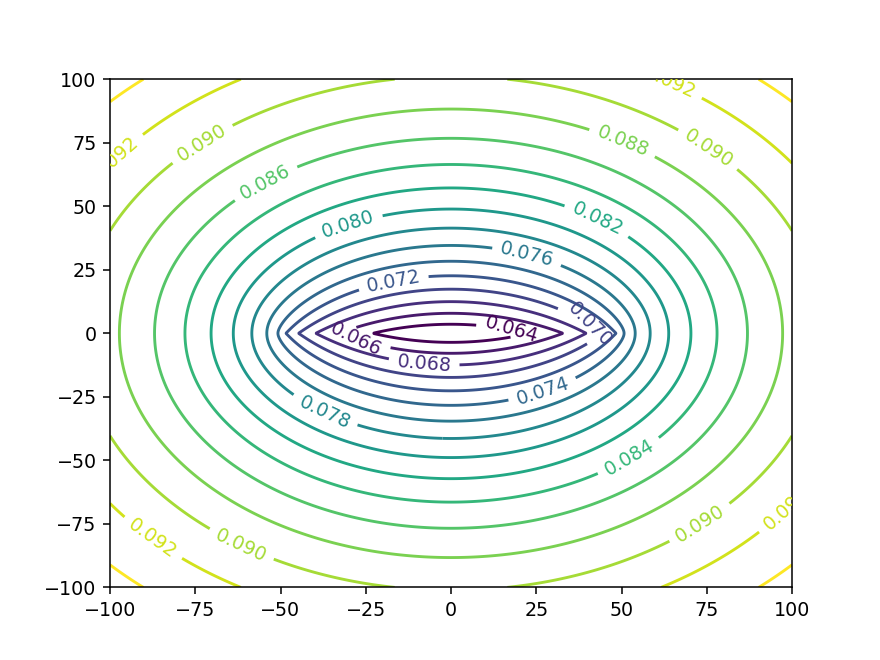

<a list of 21 text.Text objects>

In [29]:
ml = Model(T=100)
ls = LineSink(ml, x1=-50,y1=0, x2 = 50, y2=0, Q = 10)
x,y = np.meshgrid(np.linspace(-100,100,1000),np.linspace(-100,100,1000))
plt.figure()
cs = plt.contour(x,y,ml.head(x,y),20)
plt.clabel(cs)

#### Exercise 6b
Create a similar contour plot but now simulate the line-sink with 10 wells with discharge $Q=1$ m$^3$/d
equally distributed along the line-sink. Does the plot compare well to the plot of the line-sink?

<IPython.core.display.Javascript object>


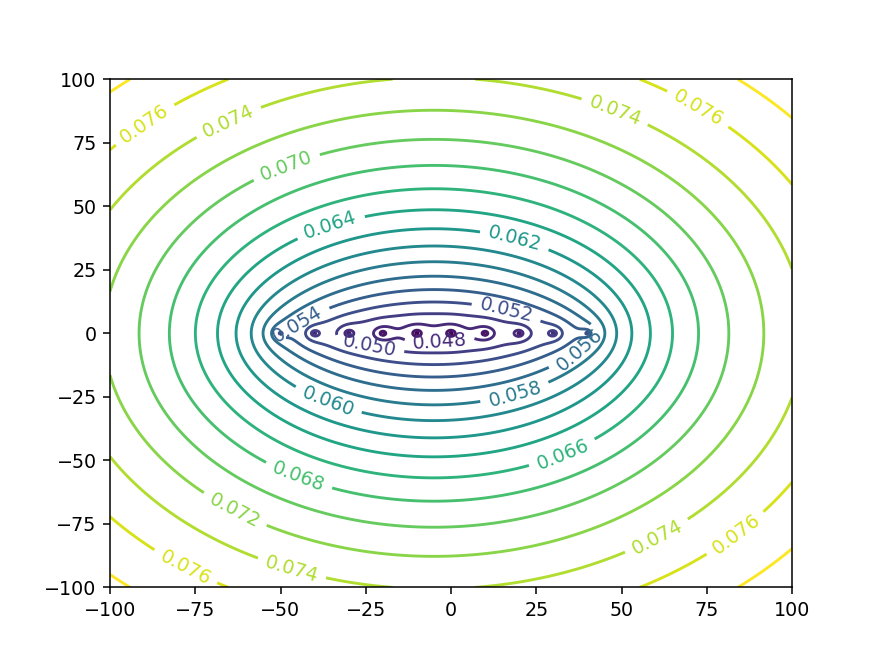

<a list of 21 text.Text objects>

In [30]:
ml = Model(T=100)
X = np.arange(-50,50,10)
Y = np.zeros((100))
for i in range(len(X)):
     w= Well(ml,X[i],Y[i],Q=1)
x,y = np.meshgrid(np.linspace(-100,100,1000),np.linspace(-100,100,1000))
plt.figure()
cs = plt.contour(x,y,ml.head(x,y),20)
plt.clabel(cs)

#### Exercise 6c
Change the line-sink of question *a* to a `HeadLineSink` with a head equal to 10 m and make a contour plot. Don't forget to solve. Check that the head at the center of the line-sink is indeed 10. Note that the head is not uniform along the line-sink. The inflow is uniform and the head is only equal to 10 at the center of the line-sink.

<IPython.core.display.Javascript object>


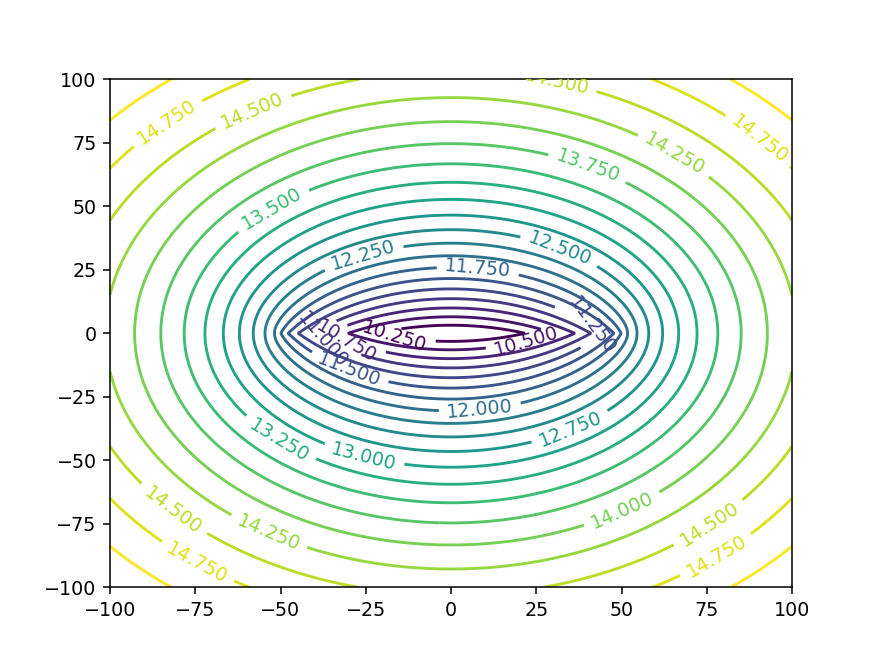

<a list of 26 text.Text objects>

In [31]:
ml_6c = Model(T=100)
ls_6c = HeadLineSink(ml_6c, x1= -50,y1=0, x2=50, y2=0, h=10.0)
ml_6c.solve()
x,y = np.meshgrid(np.linspace(-100,100,1000),np.linspace(-100,100,1000))
ml_6c.head(10,0)
plt.figure()
cs = plt.contour(x,y,ml_6c.head(x,y),20)
plt.clabel(cs)

#### Exercise 6d
Replace the `HeadLineSink` of the previous question with 10 `HeadLineSink` elements to simulate a constant
head along the stretch more accurately.

<IPython.core.display.Javascript object>


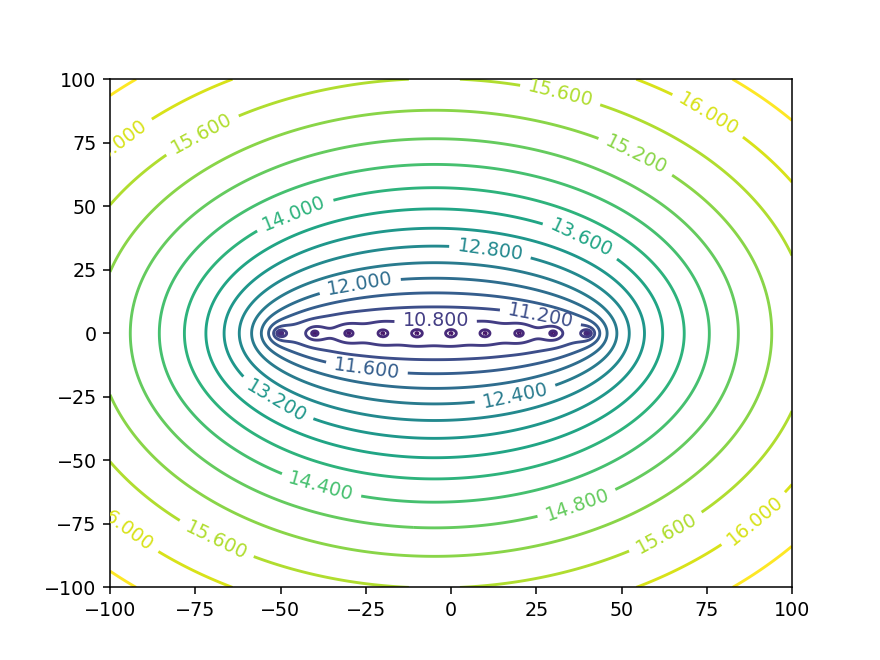

<a list of 20 text.Text objects>

In [32]:
ml_6d = Model(T=100)
X = np.arange(-50,50,10)
Y = np.zeros((100))
for i in range(len(X)):
     w= HeadWell(ml_6d,X[i],Y[i],h=10)
ml_6d.solve()
x,y = np.meshgrid(np.linspace(-100,100,1000),np.linspace(-100,100,1000))
plt.figure()
cs = plt.contour(x,y,ml_6d.head(x,y),20)
plt.clabel(cs)

#### Exercise 6e
Compute the discharge per unit length of each line-sink and make a bar plot showing the variation of inflow along the line-sink.

<IPython.core.display.Javascript object>


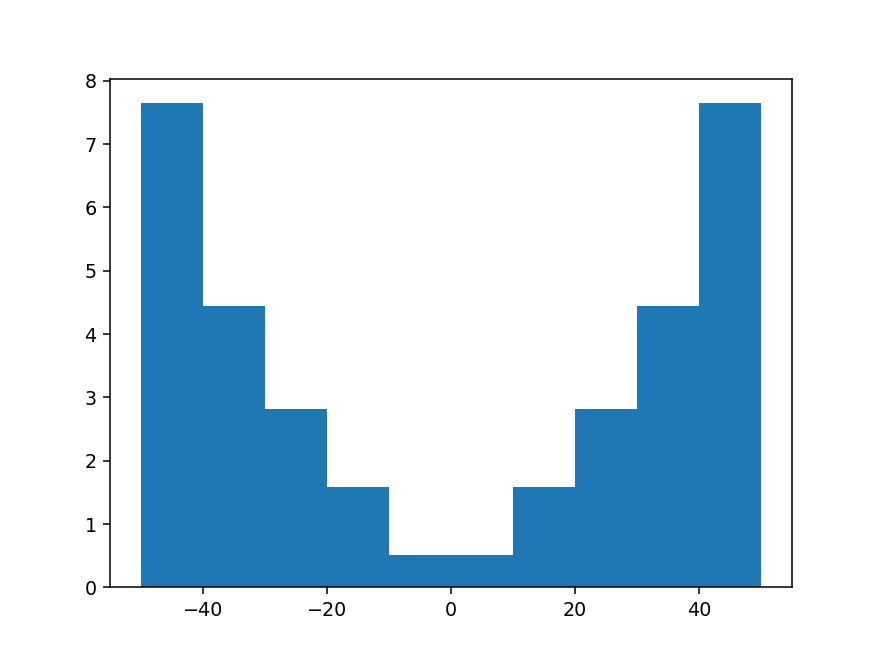

<Container object of 10 artists>

In [33]:
X_left = np.arange(-50,50,10)+2.5
X_right = np.arange(-50,50,10)+7.5
Y = np.zeros(10)
Potential_left = ls_6c.potential(X_left,Y)
Potential_right = ls_6c.potential(X_right,Y)
Q = abs(Potential_left - Potential_right)/5
plt.figure()
plt.bar((X_left+X_right)/2,Q,10,align = 'center')